In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import cv2
from PIL import Image, ImageDraw
from lang_sam import LangSAM
from matplotlib import pyplot as plt

load_dotenv()
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
options = os.getenv("OPTIONS").split(",")
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
features = os.getenv("FEATURES").split(",")

image = cv2.imread("parking2.jpg")
image_height, image_width, _ = image.shape
image_area = image_width * image_height

c:\Python311\Lib\site-packages\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [44]:
query = "Select the white car."

In [45]:
sentence_embedding = sentence_model.encode([query])[0]
options_embeddings = sentence_model.encode(options)

similarities = {}
for i, option in enumerate(options):
    similarity = np.dot(sentence_embedding, options_embeddings[i]) / (np.linalg.norm(sentence_embedding) * np.linalg.norm(options_embeddings[i]))
    similarities[option] = similarity

best_option = max(similarities, key=similarities.get)

print(f"Most Probability world is '{best_option}' with similarity {similarities[best_option]:.4f}")

Most Probability world is 'car' with similarity 0.6655


In [4]:
def get_filter_code(prompt: str) -> str:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt,
        max_tokens=1000,
        temperature=0,
    )
    
    return response.choices[0].message.content

In [10]:
model_sam = LangSAM()
image_pil = Image.open("parking2.jpg").convert("RGB")
results = model_sam.predict([image_pil], [f"{best_option}."], box_threshold=0.23)

Predicting 1 masks
Predicted 1 masks


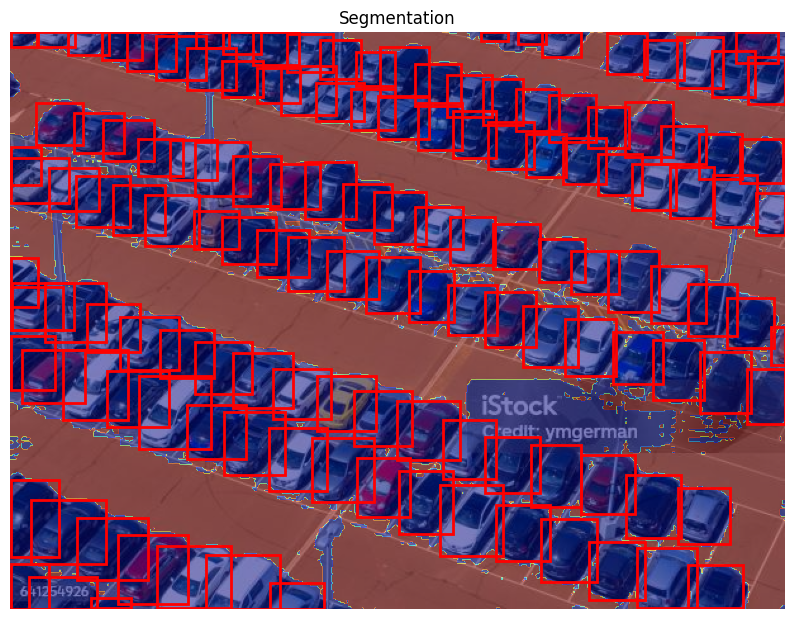

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image_pil)
plt.axis('off')

for result in results:
    # Itera sulle copie dei box per filtrare quelli da rimuovere
    for i, box in enumerate(result["boxes"]):
        x_min, y_min, x_max, y_max = box
        area = (x_max - x_min) * (y_max - y_min) / image_area
        if area > 0.8:
            # Rimuovi il box con numpy.delete
            result["boxes"] = np.delete(result["boxes"], i, axis=0)
            continue
        # Disegna il box valido
        plt.gca().add_patch(plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            edgecolor='red', facecolor='none', linewidth=2, label="Box"
        ))

    # Visualizza la maschera
    mask = result["masks"][0]
    plt.imshow(mask, cmap='jet', alpha=0.5)

plt.title("Segmentation")
plt.show()

In [46]:
points_array = np.array([
    [
        [row[0], row[1]],
        [row[2], row[1]],
        [row[2], row[3]],
        [row[0], row[3]]
    ]
    for row in results[0]['boxes']
])

def calculate_features(points, image):
    # Determina i limiti del rettangolo
    x_min = min(p[0] for p in points)
    x_max = max(p[0] for p in points)
    y_min = min(p[1] for p in points)
    y_max = max(p[1] for p in points)

    # Calcola area e dimensioni relative
    area = (x_max - x_min) * (y_max - y_min)
    image_area = image.shape[0] * image.shape[1]
    relative_area = area / image_area
    relative_height = (y_max - y_min) / image.shape[0]
    relative_width = (x_max - x_min) / image.shape[1]

    # Coordinate medie
    mean_x = np.mean([p[0] for p in points])
    mean_y = np.mean([p[1] for p in points])

    # Ritaglia l'area specificata
    cropped_area = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    # Escludi i bordi (considera solo i pixel centrali)
    center_y = cropped_area.shape[0] // 2
    center_x = cropped_area.shape[1] // 2
    offset = min(cropped_area.shape[0] // 4, cropped_area.shape[1] // 4)  # Finestra 10x10 o proporzionale
    cropped_center = cropped_area[
        max(0, center_y - offset):min(center_y + offset, cropped_area.shape[0]),
        max(0, center_x - offset):min(center_x + offset, cropped_area.shape[1])
    ]

    # Converte l'immagine in formato RGB per calcolare l'istogramma
    cropped_center_rgb = cv2.cvtColor(cropped_center, cv2.COLOR_BGR2RGB)

    # Calcola l'istogramma per ogni canale (R, G, B)
    hist_r = cv2.calcHist([cropped_center_rgb], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([cropped_center_rgb], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([cropped_center_rgb], [2], None, [256], [0, 256])

    # Determina il colore predominante come il valore massimo dell'istogramma
    dominant_r = int(np.argmax(hist_r))
    dominant_g = int(np.argmax(hist_g))
    dominant_b = int(np.argmax(hist_b))

    # Classifica il colore in categorie
    if dominant_r > 200 and dominant_g < 100 and dominant_b < 100:
        color_category = "red"
    elif dominant_r < 100 and dominant_g > 200 and dominant_b < 100:
        color_category = "green"
    elif dominant_r < 100 and dominant_g < 100 and dominant_b > 200:
        color_category = "blue"
    elif dominant_r > 200 and dominant_g > 200 and dominant_b < 100:
        color_category = "yellow"
    elif dominant_r > 200 and dominant_g > 200 and dominant_b > 200:
        color_category = "white"
    elif dominant_r < 50 and dominant_g < 50 and dominant_b < 50:
        color_category = "black"
    else:
        color_category = "other"

    # Ritorna le caratteristiche calcolate
    return {
        "coord_1": points[0],
        "coord_2": points[1],
        "coord_3": points[2],
        "coord_4": points[3],
        "mean_x": mean_x,
        "mean_y": mean_y,
        "mean_color_R": dominant_r,
        "mean_color_G": dominant_g,
        "mean_color_B": dominant_b,
        "color_category": color_category,
        "area": area,
        "relative_area": relative_area,
        "relative_height": relative_height,
        "relative_width": relative_width
    }

dataset = []
for points in points_array:
    features_dict = calculate_features(points, image)
    dataset.append(features_dict)

df = pd.DataFrame(dataset)

df.head()

,coord_1,coord_2,coord_3,coord_4,mean_x,mean_y,mean_color_R,mean_color_G,mean_color_B,color_category,area,relative_area,relative_height,relative_width
0,"[527.3987, 360.08112]","[567.73444, 360.08112]","[567.73444, 403.8291]","[527.3987, 403.8291]",547.566528,381.955109,127,167,200,other,1764.608032,0.006323,0.095939,0.065908
1,"[419.6571, -0.035330236]","[450.19617, -0.035330236]","[450.19617, 19.702547]","[419.6571, 19.702547]",434.926636,9.833609,165,195,206,other,602.776245,0.002160,0.043285,0.049900
2,"[588.2431, 126.95752]","[611.5698, 126.95752]","[611.5698, 160.15787]","[588.2431, 160.15787]",599.906494,143.557693,242,255,255,white,774.455261,0.002775,0.072808,0.038116
3,"[535.1211, 421.09146]","[578.1148, 421.09146]","[578.1148, 454.92853]","[535.1211, 454.92853]",556.617920,438.010010,0,32,56,other,1454.781128,0.005213,0.074204,0.070251
4,"[416.9762, 162.96815]","[453.8191, 162.96815]","[453.8191, 197.03537]","[416.9762, 197.03537]",435.397644,180.001770,91,115,145,other,1255.134888,0.004498,0.074709,0.060201


In [47]:
messages = [
    {"role": "system", "content": "You are an assistant that helps write Python code."},
    {"role": "user", "content": 
    f"""
        Considering the following {df.columns} columns in pandas dataframes. Image dimensions are {image_width}x{image_height} and the area is {image_area}.
        The user's query is: "{query}".

        If the query includes a color filter, use the color_category column instead of RGB values. Ensure the code filters rows where the color_category matches the requested color or applies any specified conditions on this feature.

        Write the Python code based on the query and assign to a variable called filtered_data. Notice that you have to aggregate in some cases. 
        Do not include comments or import statements or library, only the Python code.
        """}
]
try:
    filter_code = get_filter_code(prompt=messages).replace("```python", "").replace("```", "").strip()
    print(filter_code)
    exec(filter_code)
except Exception as e:
    print(f"An error occurred: {e}")

filtered_data = df[df['color_category'] == 'white']


In [43]:
if len(filtered_data) == 0:
    print("No data found.")
else:
    original_image = Image.open("parking2.jpg")

    # Copia per disegnare i rettangoli sull'immagine originale
    highlighted_image = original_image.copy()
    draw = ImageDraw.Draw(highlighted_image)

    # Crea un'immagine nera per visualizzare solo i rettangoli
    rectangles_image = Image.new("RGB", original_image.size, (0, 0, 0))

    # Itera su ogni riga del dataset per ritagliare e disegnare i rettangoli
    for _, row in filtered_data.iterrows():
        # Estrai le coordinate come tuple esplicite
        rect_coords = [
            tuple(map(int, row["coord_1"])),
            tuple(map(int, row["coord_2"])),
            tuple(map(int, row["coord_3"])),
            tuple(map(int, row["coord_4"]))
        ]

        # Disegna il rettangolo sull'immagine originale
        draw.polygon(rect_coords, outline="red", width=2)

        # Ritaglia il rettangolo dall'immagine originale
        x1, y1 = rect_coords[0]
        x3, y3 = rect_coords[2]
        cropped_rectangle = original_image.crop((x1, y1, x3, y3))

        # Sovrapponi il rettangolo sull'immagine nera
        rectangles_image.paste(cropped_rectangle, (x1, y1))

    # Visualizza le immagini
    plt.figure(figsize=(12, 6))

    # Immagine originale con rettangoli evidenziati
    plt.subplot(1, 2, 1)
    plt.imshow(highlighted_image)
    plt.title("Original Image with Highlighted Rectangles")
    plt.axis("off")

    # Immagine composta solo dai rettangoli
    plt.subplot(1, 2, 2)
    plt.imshow(rectangles_image)
    plt.title("Image with Rectangles Only")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

No data found.
